<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/batch_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Why Normalize inputs
  - Normalized inputs ensure optimizers treat each input dimension in the same manner
  - Numerical stability ensuring weights do not go bonkers
  - Reguarlization
    - Noise injection during training time
- $BN(x) = a * [x-avg(x)]/std(x) + b$
  - Normalize to 0 mean, 1 variance and increase scale to scale a, b
  - a, b are learnable parameters
- BatchNorm allows for aggressive learning rates
- BN is typically applied after conv but before non linear activation
- For image of shape (N, C, H, W), for each channel is normalized over (N, H, W). N batch norm layers are generated

In [1]:
!pip install d2l
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

device_type = 'cpu'
if torch.cuda.is_available():
  device_type = 'cuda'

device = torch.device(device_type)
device

device(type='cuda')

In [2]:
bn = nn.BatchNorm2d(256)
t = torch.randn((1, 256, 128, 128))
o = bn(t)

o.shape, bn.weight.size(), bn.bias.size()

(torch.Size([1, 256, 128, 128]), torch.Size([256]), torch.Size([256]))

In [6]:
def batch_norm(x):
  """
  Batch normalization
    x - input tensor of shape (N, C, H, W)

  Returns
    x - normalized tensor of shape (N, C, H, W)
  """
  (n, c, h, w) = x.shape
  weight_scale = torch.tensor(c)
  bias_scale = torch.tensor(c)

  mean = x.mean(dim=(0, 2, 3))
  std = x.std(dim=(0, 2, 3))

  x = x.permute(0, 2, 3, 1)

  xh = (x-mean)/std
  o = xh * weight_scale + bias_scale

  return o.permute(0, 3, 1, 2)

t = torch.randn((2, 3, 10, 10))
batch_norm(t).shape


torch.Size([2, 3, 10, 10])

In [7]:
class BatchNorm2d(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return batch_norm(x)

t = torch.randn((2, 3, 10, 10))
batchnorm = BatchNorm2d()
batchnorm(t).shape

torch.Size([2, 3, 10, 10])

In [8]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNetWithBatchNorm(d2l.Classifier):
  def __init__(self, num_classes=10, lr=0.1):
    super().__init__()
    self.lr = lr
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        BatchNorm2d(),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2),

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        BatchNorm2d(),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2),

        nn.Flatten(),
        nn.LazyLinear(120),
        nn.Sigmoid(),
        nn.LazyLinear(84),
        nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, x):
    return self.net(x)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
      X = layer(X)
      print(layer.__class__.__name__, "output shape = ", X.shape)



model = LeNetWithBatchNorm()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape =  torch.Size([1, 6, 28, 28])
BatchNorm2d output shape =  torch.Size([1, 6, 28, 28])
Sigmoid output shape =  torch.Size([1, 6, 28, 28])
AvgPool2d output shape =  torch.Size([1, 6, 14, 14])
Conv2d output shape =  torch.Size([1, 16, 10, 10])
BatchNorm2d output shape =  torch.Size([1, 16, 10, 10])
Sigmoid output shape =  torch.Size([1, 16, 10, 10])
AvgPool2d output shape =  torch.Size([1, 16, 5, 5])
Flatten output shape =  torch.Size([1, 400])
Linear output shape =  torch.Size([1, 120])
Sigmoid output shape =  torch.Size([1, 120])
Linear output shape =  torch.Size([1, 84])
Sigmoid output shape =  torch.Size([1, 84])
Linear output shape =  torch.Size([1, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


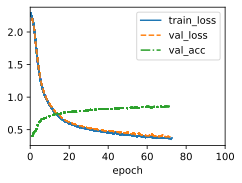

In [ ]:

def get_loss(model, data):
  model.train = False

  losses, access = [], []
  for (inputs, outputs) in data.val_dataloader():
    preds = model.forward(inputs.to(device))
    loss = model.loss(preds, outputs.to(device)).item()
    acc = model.accuracy(preds, outputs.to(device)).item()
    losses.append(loss)
    access.append(acc)

  return np.mean(np.array(losses)), np.mean(np.array(access))


trainer = d2l.Trainer(max_epochs=100, num_gpus=1)
data = d2l.FashionMNIST(batch_size=1000)

modern_model = LeNetWithBatchNorm(lr=0.1)
modern_model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(modern_model, data)
get_loss(modern_model, data)